In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import gym
from gym import spaces
import random
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings("ignore")
# from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
folder_path = '../csv/solar_energy_prod'
all_csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

df_list = [pd.read_csv(file) for file in all_csv_files]

df = pd.concat(df_list, ignore_index=True)

print(df.shape)
df.head()

(258423, 8)


,name,id,address,date,kWh,public_url,installationDate,uid
0,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 08:00:00 AM,1.130,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 08:00:00
1,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 09:00:00 AM,2.340,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 09:00:00
2,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 10:00:00 AM,3.656,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 10:00:00
3,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 11:00:00 AM,4.577,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 11:00:00
4,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 12:00:00 PM,6.506,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 12:00:00


# Data Preparation

In [3]:
print(df.dtypes)
df['kWh'].describe()

name                 object
id                    int64
address              object
date                 object
kWh                 float64
public_url           object
installationDate     object
uid                  object
dtype: object


count    258423.000000
mean         38.059762
std          71.598031
min           0.000000
25%           1.370000
50%           8.034000
75%          35.876000
max         514.462000
Name: kWh, dtype: float64

In [4]:
df['datetime']=pd.to_datetime(df['date'])
df.sort_values(by=['name','datetime'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,name,id,address,date,kWh,public_url,installationDate,uid,datetime
0,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017/11/21 10:45:00 AM,0.970,https://monitoring.solaredge.com/solaredge-web...,2017/10/31,5776502017-11-21 10:45:00,2017-11-21 10:45:00
1,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017/11/21 11:45:00 AM,23.927,https://monitoring.solaredge.com/solaredge-web...,2017/10/31,5776502017-11-21 11:45:00,2017-11-21 11:45:00
2,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017/11/21 12:45:00 PM,69.659,https://monitoring.solaredge.com/solaredge-web...,2017/10/31,5776502017-11-21 12:45:00,2017-11-21 12:45:00
3,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017/11/21 01:45:00 PM,59.172,https://monitoring.solaredge.com/solaredge-web...,2017/10/31,5776502017-11-21 13:45:00,2017-11-21 13:45:00
4,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2017/11/21 02:45:00 PM,18.061,https://monitoring.solaredge.com/solaredge-web...,2017/10/31,5776502017-11-21 14:45:00,2017-11-21 14:45:00


In [5]:
df0 = df[df.name=='Bearspaw Water Treatment Plant']
df0.count()['date']

np.int64(24869)

In [6]:
# plt.style.use('fivethirtyeight')
# plt.plot(df0.date, df0['kWh'], label='Bearspaw Water Treatment Plant Solar Energy Production')
# plt.tight_layout()
# plt.xlabel("DateTime")
# plt.ylabel("kWh Solar Produced")
# plt.xticks(rotation=30)
# plt.legend()
# plt.grid(True)

# plt.show()

In [7]:
min_max_dates = df['date'].agg(['min', 'max'])

print("Min and Max Dates:")
print(min_max_dates)

Min and Max Dates:
min    2015/09/01 02:30:00 PM
max    2023/03/16 12:00:00 PM
Name: date, dtype: object


In [8]:
# filter for two years

df1 = df0[df0.date>='2021/01/01']
min_max_dates = df1['date'].agg(['min', 'max'])

print("Min and Max Dates after date filtering:")
print(min_max_dates)

Min and Max Dates after date filtering:
min    2021/01/01 01:00:00 PM
max    2023/03/16 12:00:00 PM
Name: date, dtype: object


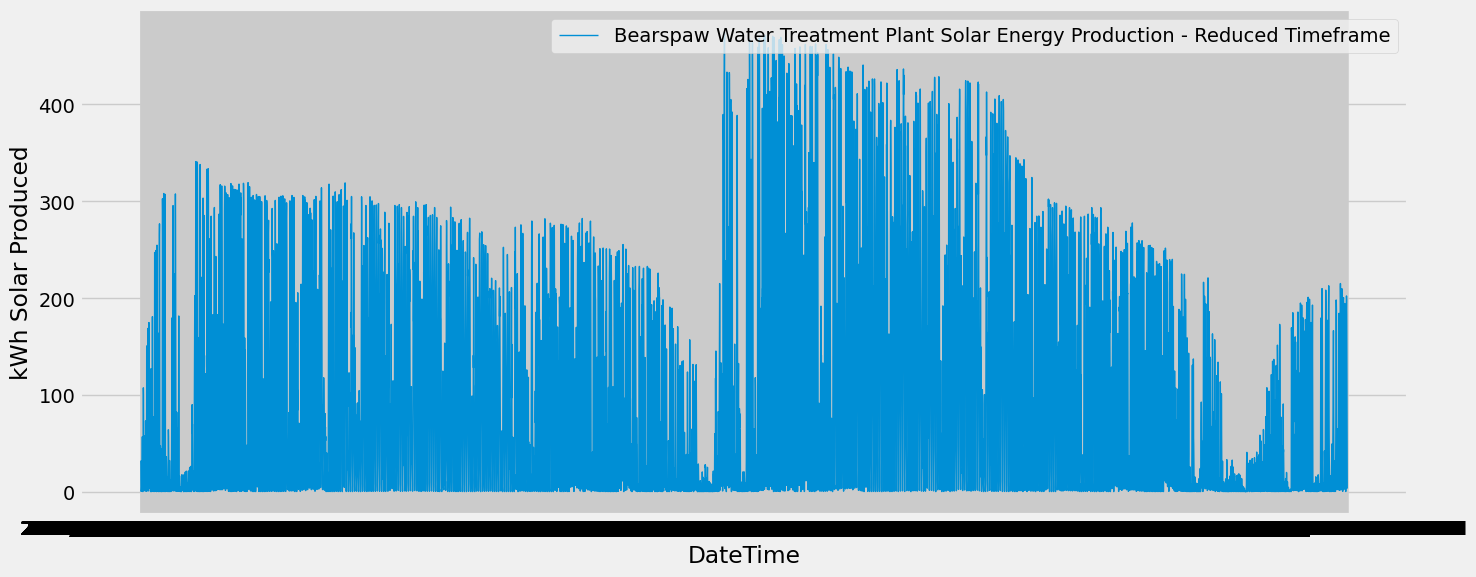

In [9]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 6))

plt.plot(df1.date, df1['kWh'], label='Bearspaw Water Treatment Plant Solar Energy Production - Reduced Timeframe', linewidth=1)
plt.xlabel("DateTime")
plt.ylabel("kWh Solar Produced")

plt.tight_layout()
plt.legend()
plt.grid(True)

plt.show()

In [10]:
df1.reset_index(inplace=True, drop=True)
df1.head()

,name,id,address,date,kWh,public_url,installationDate,uid,datetime
0,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2021/01/01 08:00:00 AM,0.007,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502021-01-01 08:00:00,2021-01-01 08:00:00
1,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2021/01/01 09:00:00 AM,0.800,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502021-01-01 09:00:00,2021-01-01 09:00:00
2,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2021/01/01 10:00:00 AM,1.600,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502021-01-01 10:00:00,2021-01-01 10:00:00
3,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2021/01/01 11:00:00 AM,4.809,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502021-01-01 11:00:00,2021-01-01 11:00:00
4,Bearspaw Water Treatment Plant,577650,11444 Bearspaw Dam RD NW,2021/01/01 12:00:00 PM,28.590,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502021-01-01 12:00:00,2021-01-01 12:00:00


### Seasonality

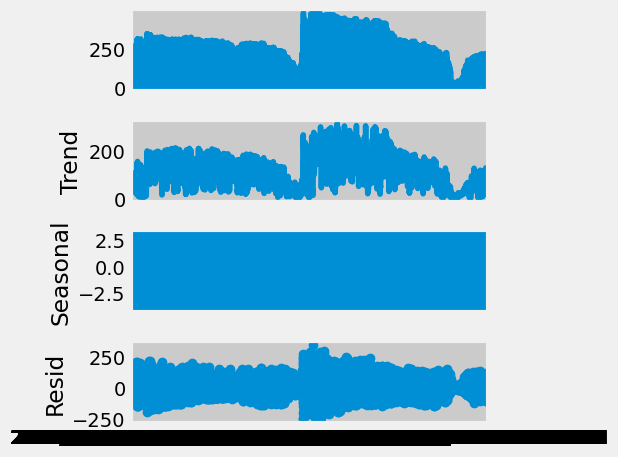

In [21]:
df_ts = df1[['date','kWh']].set_index('date')

# Decompose the time series (assuming monthly seasonality, period=12)
decomposition = seasonal_decompose(df_ts, model='additive', period=12)

# Plot the decomposed components
fig = decomposition.plot()
plt.show()

# Access individual components
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

# Q-Learning Anomaly Detection Environment

In [24]:
class AnomalyDetectionEnv:
    def __init__(self, data):
        self.data = data
        self.current_step = 0
        self.action_space = spaces.Discrete(2)  # 0: no anomaly, 1: anomaly
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)
        self.flagged_anomalies = []  # Store flagged anomalies

    def step(self, action):
        # Get the current data point and index
        current_value = self.data[self.current_step]
        current_index = self.current_step
        
        # If the agent flags it as an anomaly, store it
        if action == 1:  # 1 means anomaly
            self.flagged_anomalies.append((current_index, current_value))
        
        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.data)
        
        # Return observation, reward, done, and info
        return np.array([current_value]), 0, done, {}

    def reset(self):
        self.current_step = 0
        self.flagged_anomalies = []  # Reset anomalies for a new episode
        return np.array([self.data[self.current_step]])

In [25]:
class QLearningAgent:
    def __init__(self, action_size):
        self.action_size = action_size
        self.q_table = {}
        self.alpha = 0.01  # Learning rate
        self.gamma = 0.95  # Discount factor
        self.epsilon = 0.75  # Exploration rate (1.0)
        self.epsilon_decay = 0.50 # 0.99
        self.epsilon_min = 0.01 # 0.1

    def get_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, self.action_size - 1)
        return np.argmax(self.q_table.get(tuple(state.flatten()), [0]*self.action_size))

    def update_q_value(self, state, action, reward, next_state):
        state_key = tuple(state.flatten())
        next_state_key = tuple(next_state.flatten())
        current_q = self.q_table.get(state_key, [0]*self.action_size)[action]
        max_future_q = max(self.q_table.get(next_state_key, [0]*self.action_size))
        
        new_q = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * max_future_q)
        if state_key not in self.q_table:
            self.q_table[state_key] = [0] * self.action_size
        self.q_table[state_key][action] = new_q

In [26]:
# Training the agent
env = AnomalyDetectionEnv(df1['kWh'].values)
agent = QLearningAgent(env.action_space.n)
num_episodes = 100

for episode in range(num_episodes):
    state = env.reset()
    done = False
    while not done:
        # Agent selects an action
        action = agent.get_action(state)
        # Environment responds to the action
        next_state, reward, done, _ = env.step(action)
        agent.update_q_value(state, action, reward, next_state)
        state = next_state
    agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)

In [27]:
# Print flagged anomalies
# print("Flagged anomalies:", env.flagged_anomalies)

In [28]:
# Extract anomaly indexes
anomaly_indexes = {index for index, value in env.flagged_anomalies}

# Add a new column to the DataFrame
df1['Is_Anomaly'] = df1.index.isin(anomaly_indexes).astype(int)
#df1['anomaly_boolean'] = df1['Is_Anomaly'].astype(bool)

In [29]:
df1['Is_Anomaly'].sum()

np.int64(57)

In [30]:
# df1[df1.Is_Anomaly==1]

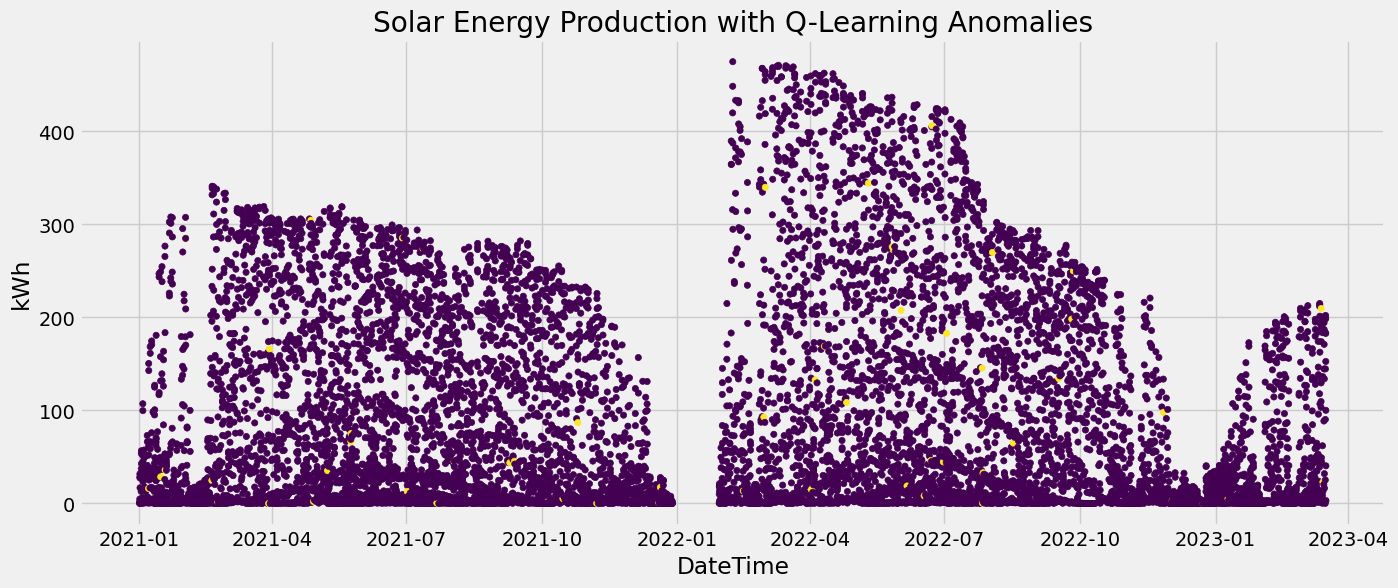

In [31]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 6))

plt.scatter(df1['datetime'], df1['kWh'], c=df1.Is_Anomaly, s=20) # 's' for marker size

plt.xlabel('DateTime')
plt.ylabel('kWh')
plt.title('Solar Energy Production with Q-Learning Anomalies')
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the agent
# state = env.reset()
# done = False
# total_reward = 0

# while not done:
#     action = agent.get_action(state)
#     next_state, reward, done, _ = env.step(action)
#     total_reward += reward
#     state = next_state

# print(f'Total reward during evaluation: {total_reward}')

# Let's compare the Q-Learning anomalies with the results from an Isolation Forest

### Features for Model

In [34]:
df2 = df1.sort_values("date")

window = 12 # window to half-days, since the data is collected hourly

# Calculate rolling mean, minimum 1 period to avoid NaN
df2["rolling_mean"] = df2["kWh"].rolling(window=window, min_periods=1).mean()

# Calculate rolling standard deviation, minimum 1 period
df2["rolling_std"] = df2["kWh"].rolling(window=window, min_periods=1).std()

# Calculate rolling maximum, minimum 1 period
df2["rolling_max"] = df2["kWh"].rolling(window=window, min_periods=1).max()

# Calculate rolling minimum, minimum 1 period
df2["rolling_min"] = df2["kWh"].rolling(window=window, min_periods=1).min()

# Create lag features: value shifted by 1
df2["lag_1"] = df2["kWh"].shift(1)

# Create lag features: value shifted by 6
df2["lag_6"] = df2["kWh"].shift(6)

# Calculate the percentage change from the previous value
df2["pct_change"] = df2["kWh"].pct_change()

In [35]:
feature_cols = [
    "kWh",
    "rolling_mean",
    "rolling_std",
    "rolling_max",
    "rolling_min",
    "lag_1",
    "lag_6",
    "pct_change",
]

df2[feature_cols] = df2[feature_cols].replace([np.inf, -np.inf], np.nan)
df2[feature_cols] = df2[feature_cols].fillna(method="ffill").fillna(method="bfill")

In [38]:
# Initialize RobustScaler to scale features while being robust to outliers
scaler = RobustScaler()

# Fit the scaler on the feature matrix and transform the features accordingly
X = scaler.fit_transform(df2[feature_cols])

In [39]:
def estimate_contamination(X):
    """
    Estimate the contamination rate based on the proportion of outliers in each feature.
    
    Parameters:
    - X: numpy array of feature values
    
    Returns:
    - average_contamination: float representing the average contamination rate across features
    """
    outlier_proportions = []
    for feature_idx in range(X.shape[1]):
        # Extract all values for the current feature
        feature_values = X[:, feature_idx]
        
        # Calculate mean and standard deviation of the feature
        mean = np.mean(feature_values)
        std = np.std(feature_values)
        
        # Count the number of outliers beyond 3 standard deviations from the mean
        outliers = np.sum(np.abs(feature_values - mean) > 3 * std)
        
        # Calculate the proportion of outliers in the current feature
        outlier_proportions.append(outliers / len(feature_values))
    
    # Return the average contamination rate across all features
    return np.mean(outlier_proportions)

In [42]:
# Estimate the contamination rate
contamination = estimate_contamination(X)
contamination

np.float64(0.0047473240016467685)

In [43]:
# Instead, let's bound the contamination rate between 1% and 20% to ensure reasonable model assumptions
contamination = min(max(contamination, 0.01), 0.2)  # Bound between 1% and 20%
contamination

0.01

### Isolation Forest Model Training and Prediction

In [44]:
X_train, X_val = train_test_split(X, test_size=0.2, random_state=12)

clf = IsolationForest(contamination=contamination, random_state=12)

# Fit the Isolation Forest model on the training data
clf.fit(X_train)

,n_estimators,100
,max_samples,'auto'
,contamination,0.01
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,12
,verbose,0
,warm_start,False


In [48]:
# Predict anomalies on the entire dataset using the trained Isolation Forest model
df2["isolation_forest_anomaly"] = clf.predict(X)

# Map the predictions to binary labels: 0 for normal instances, 1 for anomalies
df2["isolation_forest_anomaly"] = df2["isolation_forest_anomaly"].map({1: 0, -1: 1})  # Convert to 0 (normal) and 1 (anomaly)

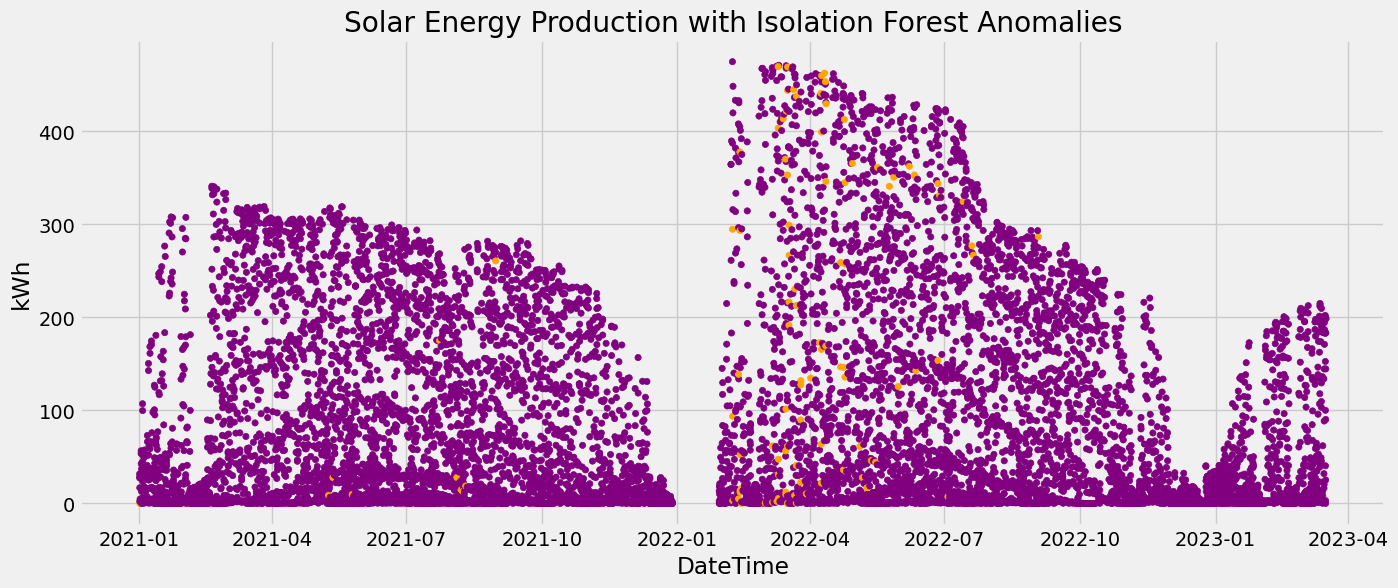

In [55]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 6))

color_map = {
    0: 'purple',
    1: 'orange'
}

colors = [color_map[cat] for cat in df2['isolation_forest_anomaly']]

plt.scatter(df2['datetime'], df1['kWh'], c=colors, s=20) # 's' for marker size

plt.xlabel('DateTime')
plt.ylabel('kWh')
plt.title('Solar Energy Production with Isolation Forest Anomalies')
plt.grid(True)
plt.show()

In [53]:
df2['model_anomaly_match'] = np.where((df2.Is_Anomaly==1) & (df2.isolation_forest_anomaly==1), 1,0)

df2.groupby(['Is_Anomaly','isolation_forest_anomaly','model_anomaly_match']).agg({'datetime':'count'}).reset_index()

,Is_Anomaly,isolation_forest_anomaly,model_anomaly_match,datetime
0,0,0,0,9554
1,0,1,0,105
2,1,0,0,57


### None of the anomalies match between models, so this requires some EDA and model tuning!